# SET UP

In [1]:
### Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import emoji
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from joblib import dump, load

pd.options.display.float_format = "{:.1f}".format
sns.set_theme(style = "darkgrid", rc = {"figure.figsize": (14, 6)})

In [2]:
### Load pipeline
nlp = spacy.load("en_core_web_sm", disable = ["tok2vec", "parser", "ner"])
nlp.add_pipe("spacytextblob")

# LOAD DATA

In [3]:
### Import Spotify app reviews dataset
df = pd.read_csv("./Data/Reviews.csv", header = 0, names = ["Review_Time", "Review", "Rating", "Thumbs_Up", "Reply"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review_Time  61594 non-null  object
 1   Review       61594 non-null  object
 2   Rating       61594 non-null  int64 
 3   Thumbs_Up    61594 non-null  int64 
 4   Reply        216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB
None


In [4]:
### Glimpse of data
df.head()

,Review_Time,Review,Rating,Thumbs_Up,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


# TRANSFORM

In [5]:
### Change data type
df["Review_Time"] = pd.to_datetime(df["Review_Time"], format = "%Y-%m-%d %H:%M:%S")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Review_Time  61594 non-null  datetime64[ns]
 1   Review       61594 non-null  object        
 2   Rating       61594 non-null  int64         
 3   Thumbs_Up    61594 non-null  int64         
 4   Reply        216 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.3+ MB
None


In [6]:
### Drop duplicate reviews
df.drop_duplicates(subset = ["Review"], inplace = True)

In [7]:
### Add review date and month
df["Review_Date"] = df["Review_Time"].dt.date
df["Review_Date"] = pd.to_datetime(df["Review_Date"], format = "%Y-%m-%d")
df["Review_Month"] = df["Review_Date"].dt.month

In [8]:
### View summary statistics
df.describe(datetime_is_numeric = True)

,Review_Time,Rating,Thumbs_Up,Review_Date,Review_Month
count,61356,61356.0,61356.0,61356,61356.0
mean,2022-04-20 10:25:45.314280448,3.2,7.7,2022-04-19 21:47:26.626246912,4.1
min,2022-01-01 00:19:09,1.0,0.0,2022-01-01 00:00:00,1.0
25%,2022-03-08 19:27:30,1.0,0.0,2022-03-08 00:00:00,3.0
50%,2022-04-21 21:52:55.500000,3.0,0.0,2022-04-21 00:00:00,4.0
75%,2022-06-03 07:30:47.750000128,5.0,1.0,2022-06-03 00:00:00,6.0
max,2022-07-09 15:00:00,5.0,8195.0,2022-07-09 00:00:00,7.0
std,NaN,1.7,89.5,NaN,1.7


In [9]:
def clean_text(df, text_column):
    """Returns cleaned versions of the input column"""
    stop_words = list(spacy.lang.en.stop_words.STOP_WORDS)

    new_column = str(text_column) + "_Cleaned"
    new_column2 = str(text_column) + "_Cleaned_2"

    df[new_column] = df[text_column].apply(lambda x: contractions.fix(x))
    df[new_column] = df[new_column].apply(lambda x: emoji.demojize(x))
    df[new_column] = df[new_column].str.replace("[^a-zA-Z0-9]+", " ", regex = True)
    df[new_column] = df[new_column].str.replace("\d", "", regex = True)
    df[new_column] = df[new_column].apply(lambda x: " ".join(x.split()))
    df[new_column] = df[new_column].str.lower()
    df[new_column] = df[new_column].apply(lambda x: " ".join([t.lemma_ for t in nlp(x)]))

    df[new_column2] = df[new_column].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [10]:
clean_text(df, "Review")

In [11]:
def get_length(df, text_column):
    """Returns the length of the input column"""
    new_column = str(text_column) + "_Length"

    df[new_column] = df[text_column].str.len()

In [12]:
get_length(df, "Review_Cleaned")

In [13]:
def get_polarity(df, rating_column):
    """Returns the sentiment of the input column"""
    conds = [(df[rating_column] == 1) | (df[rating_column] == 2),
            df[rating_column] == 3,
            (df[rating_column] == 4) | (df[rating_column] == 5)]
    choices = ["Negative", "Neutral", "Positive"]
    df["Multi_Sentiment"] = np.select(conds, choices, default = "TBD")

    df["Binary_Sentiment"] = np.where(df[rating_column] >= 4, "Positive", "Negative")

In [14]:
get_polarity(df, "Rating")

In [15]:
def get_subjectivity(df, text_column):
    "Returns the subjectivity of the input column"
    score_column = "Subjectivity_Score"
    subjective_column = "Subjective"
    df[score_column] = df[text_column].apply(lambda x: nlp(x)._.blob.subjectivity) 
    df[subjective_column] = np.where(df[score_column] > 0, 1, 0)

In [16]:
get_subjectivity(df, "Review_Cleaned")

In [17]:
### Glimpse of data
df.head()

,Review_Time,Review,Rating,Thumbs_Up,Reply,Review_Date,Review_Month,Review_Cleaned,Review_Cleaned_2,Review_Cleaned_Length,Multi_Sentiment,Binary_Sentiment,Subjectivity_Score,Subjective
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN,2022-07-09,7,great music service the audio is high quality ...,great music service audio high quality app eas...,109,Positive,Positive,0.7,1
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN,2022-07-09,7,please ignore previous negative rating this ap...,ignore previous negative rating app super grea...,83,Positive,Positive,0.5,1
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN,2022-07-09,7,this pop up get the best spotify experience on...,pop best spotify experience android annoying l...,100,Positive,Positive,0.6,1
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN,2022-07-09,7,really buggy and terrible to use as of recently,buggy terrible use recently,47,Negative,Negative,0.5,1
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN,2022-07-09,7,dear spotify why do i get songs that i did not...,dear spotify songs playlist shuffle play,97,Negative,Negative,0.0,0


# EDA

In [22]:
### View summary statistics
df.describe(datetime_is_numeric = True)

,Review_Time,Rating,Thumbs_Up,Review_Date,Review_Month,Review_Cleaned_Length,Subjectivity_Score,Subjective
count,61346,61346.0,61346.0,61346,61346.0,61346.0,61346.0,61346.0
mean,2022-04-20 10:16:10.327323648,3.2,7.7,2022-04-19 21:38:18.868711680,4.1,164.3,0.5,0.9
min,2022-01-01 00:19:00,1.0,0.0,2022-01-01 00:00:00,1.0,7.0,0.0,0.0
25%,2022-03-08 19:26:15,1.0,0.0,2022-03-08 00:00:00,3.0,74.0,0.4,1.0
50%,2022-04-21 21:51:00,3.0,0.0,2022-04-21 00:00:00,4.0,131.0,0.5,1.0
75%,2022-06-03 07:18:15,5.0,1.0,2022-06-03 00:00:00,6.0,221.0,0.7,1.0
max,2022-07-09 15:00:00,5.0,8195.0,2022-07-09 00:00:00,7.0,3939.0,1.0,1.0
std,NaN,1.7,89.5,NaN,1.7,121.6,0.2,0.3


In [23]:
### Print out a few reviews
df.loc[0:5, "Review_Cleaned"].tolist()

['great music service the audio is high quality and the app is easy to use also very quick and friendly support',
 'please ignore previous negative rating this app is super great i give it five stars',
 'this pop up get the best spotify experience on android is too annoying please let us get rid of this',
 'really buggy and terrible to use as of recently',
 'dear spotify why do i get songs that i did not put on my playlist and why do we have shuffle play',
 'the player controls sometimes disappear for no reason app restart forgets what i was playing but fixes the issue']

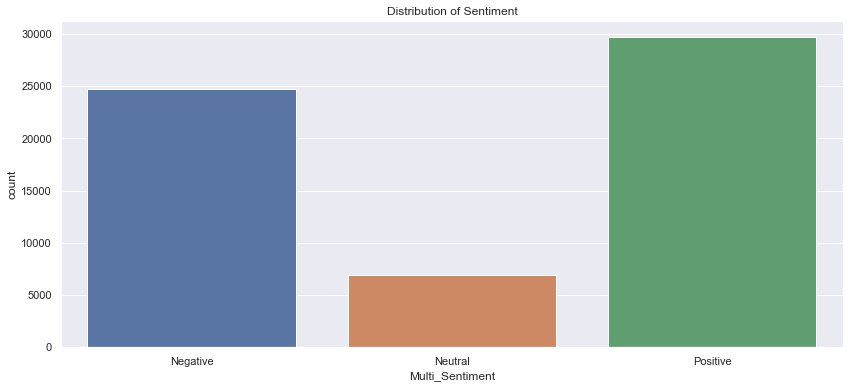

In [25]:
### Distribution of overall sentiment
sns.countplot(data = df, x = "Multi_Sentiment", order = ["Negative", "Neutral", "Positive"])
plt.title("Distribution of Sentiment")
plt.show()

In [27]:
agg_sentiment_df = df.groupby(["Multi_Sentiment"])[["Review_Time"]].agg(Count = ("Review_Time", "count")).reset_index()
agg_sentiment_df["Percent"] = agg_sentiment_df.groupby("Multi_Sentiment")["Count"].transform("sum") / agg_sentiment_df["Count"].sum() * 100
agg_sentiment_df

,Multi_Sentiment,Count,Percent
0,Negative,24716,40.3
1,Neutral,6876,11.2
2,Positive,29754,48.5


48.5% of the reviews are positive

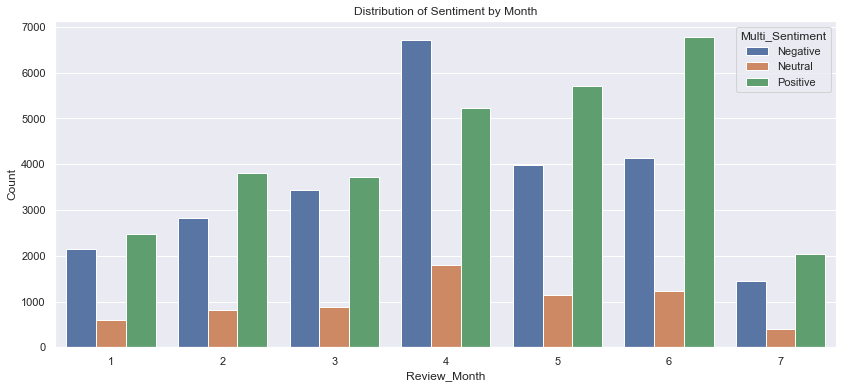

In [28]:
### Distribution of sentiment by month
agg_sentiment_month_df = df.groupby(["Review_Month", "Multi_Sentiment"])[["Review_Time"]].agg(Count = ("Review_Time", "count")).reset_index()

sns.barplot(data = agg_sentiment_month_df, x = "Review_Month", y = "Count", hue = "Multi_Sentiment",
            estimator = np.sum, ci = None)
plt.title("Distribution of Sentiment by Month")
plt.show()

In [29]:
agg_sentiment_month_df["Percent"] = agg_sentiment_month_df.groupby(["Review_Month", "Multi_Sentiment"])["Count"].transform("sum") / agg_sentiment_month_df.groupby("Review_Month")["Count"].transform("sum") * 100
agg_sentiment_month_df

,Review_Month,Multi_Sentiment,Count,Percent
0,1,Negative,2151,41.1
1,1,Neutral,600,11.5
2,1,Positive,2477,47.4
3,2,Negative,2827,37.9
4,2,Neutral,817,11.0
5,2,Positive,3812,51.1
6,3,Negative,3440,42.9
7,3,Neutral,871,10.9
8,3,Positive,3711,46.3
9,4,Negative,6723,48.9


April seems like a pivotal month. First, it has the highest percentage of negative reviews. Second, the following months, May and June, have more positive reviews than neutral and negative reviews combined

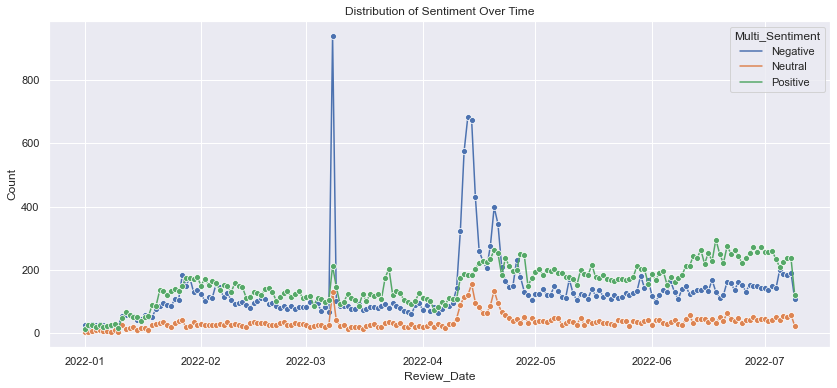

In [30]:
### Distribution of sentiment over time
agg_sentiment_date_df = df.groupby(["Review_Date", "Multi_Sentiment"])[["Review_Time"]].agg(Count = ("Review_Time", "count")).reset_index()

sns.lineplot(data = agg_sentiment_date_df, x = "Review_Date", y = "Count", hue = "Multi_Sentiment",
                marker = "o", estimator = np.sum, ci = None)
plt.title("Distribution of Sentiment Over Time")
plt.show()

The increase in positive reviews around mid-April is noticeable. In addition, there are two negative review spikes that are very prominent - lets look into them

In [31]:
### Negative reviews in March
df[(df["Review_Month"] == 3) & (df["Multi_Sentiment"] == "Negative")].groupby(["Review_Date"])[["Review_Time"]].agg(Count = ("Review_Time", "count")).reset_index().sort_values("Count", ascending = False).head(10)

,Review_Date,Count
7,2022-03-08,938
8,2022-03-09,102
1,2022-03-02,100
23,2022-03-24,95
30,2022-03-31,95
3,2022-03-04,95
21,2022-03-22,94
14,2022-03-15,94
29,2022-03-30,89
2,2022-03-03,89


In [32]:
### Slither of negative reviews on March 8th
df[(df["Review_Date"] == "2022-03-08") & (df["Multi_Sentiment"] == "Negative")].iloc[10:15, 7].tolist()

['my music is on shuffle when i did not turned it on and i do not even have a shuffle button',
 'half of playlists inaccessible because spotify thinks it is offline no fix',
 'spotify keeps failing when i really need it',
 'i go to spotify to listen to music now it treats me like i am a completely new user i have had premium for years now i have lost everything i put in my email and password and it tells me the email and password do not match which is the problem though help',
 'the bar accross the bottom continually disappears meaning i can not access the player to play pause next previous etc have to restart the app constantly which is a pain when listening to podcasts also it will just stop by itself randomly']

In [34]:
### Negative reviews in April
df[(df["Review_Month"] == 4) & (df["Multi_Sentiment"] == "Negative")].groupby(["Review_Date"])[["Review_Time"]].agg(Count = ("Review_Time", "count")).reset_index().sort_values("Count", ascending = False).head(10)

,Review_Date,Count
12,2022-04-13,684
13,2022-04-14,674
11,2022-04-12,574
14,2022-04-15,430
19,2022-04-20,398
20,2022-04-21,346
10,2022-04-11,322
18,2022-04-19,277
15,2022-04-16,261
25,2022-04-26,233


In [35]:
### Slither of negative reviews on April 13th
df[(df["Review_Date"] == "2022-04-13") & (df["Multi_Sentiment"] == "Negative")].iloc[10:15, 7].tolist()

['since the new update the player keeps cutting out randomly not impressed i have tried resetting and the error keeps happening before that i would give it stars i love the service but you need to fix the app',
 'i want to give stars but lately i have been clicking songs and they play but the playlist playing now controller does not show up galaxy s also add third party uploads i constantly have to switch to youtube for live shows',
 'i do not know why but recently i am not able to find any podcasts on the app even the ones i listened to before i used to love this app but now i am just annoyed by it fix the podcast problem and why do you add songs onto playlists when we shuffle play it it is annoying',
 'just so everyone knows spotify free is more than just ads they actively slow your device down and speed it back up when you give them money which sounds like extortion but i move on on the free version shuffle is not the same algorithm as premium mode shuffle how because they have a pr


In March, specifically on the 8th, Spotify encountered [technical problems](https://nypost.com/2022/03/08/spotify-hit-by-widespread-technical-problems/) in which users reported access issues. In April, around the week of the 10th, Spotify incorporated [Spotify Live](https://newsroom.spotify.com/2022-04-12/spotify-greenroom-is-getting-a-new-name-spotify-live-and-a-new-home/) into the app and users reported bugs after the new update


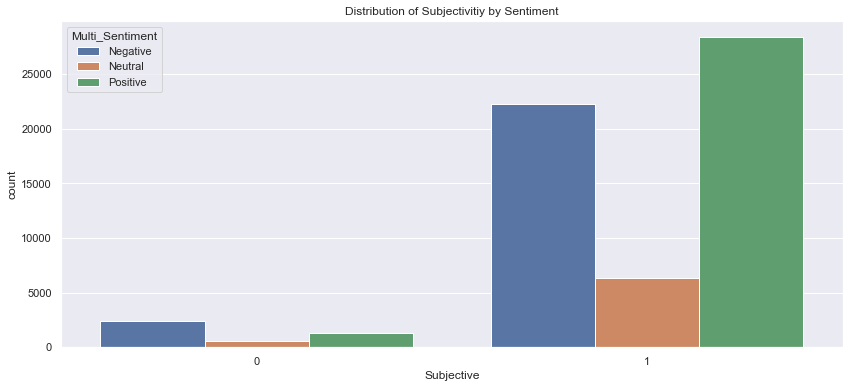

In [36]:
### Distribution of subjectivity
sns.countplot(data = df, x = "Subjective", hue = "Multi_Sentiment", hue_order = ["Negative", "Neutral", "Positive"])
plt.title("Distribution of Subjectivitiy by Sentiment")
plt.show()

In [37]:
agg_subjective_df = df.groupby(["Subjective"])[["Review_Time"]].agg(Count = ("Review_Time", "count")).reset_index()
agg_subjective_df["Percent"] = agg_subjective_df.groupby("Subjective")["Count"].transform("sum") / agg_subjective_df["Count"].sum() * 100
agg_subjective_df

,Subjective,Count,Percent
0,0,4254,6.9
1,1,57092,93.1


93.1% of the reviews are subjective

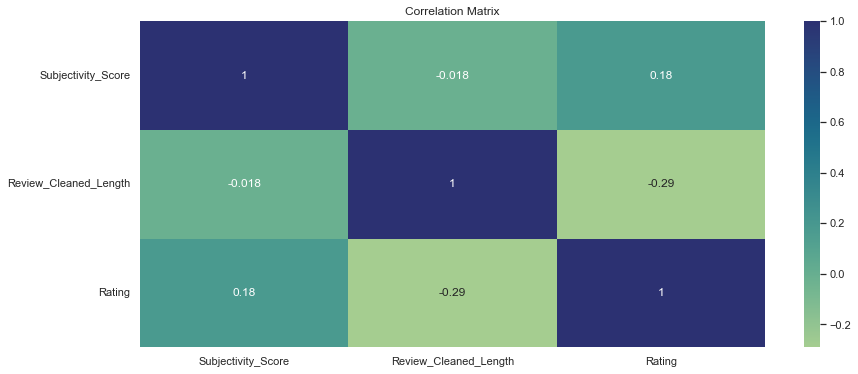

In [38]:
### Correlation matrix
sns.heatmap(data= df[["Subjectivity_Score", "Review_Cleaned_Length", "Rating"]].corr(), annot = True, cmap = "crest")
plt.yticks(rotation = 360)
plt.title("Correlation Matrix")
plt.show()

The subjectivity and length of the reviews have a weak correlation with the app rating: (1) the higher the subjectivity, the higher the rating and (2) the longer the review, the lower the rating

# MULTI-CLASSIFICATION

In [39]:
### Set up modeling parameters
cv = KFold(5)
rng = np.random.RandomState(123)

### TRAIN/TEST SETS

In [40]:
### Determine a representative distribution of the three classes
X_train, X_test, Y_train, Y_test = train_test_split(df["Review_Cleaned"], df["Multi_Sentiment"], train_size = 0.75, stratify = df["Multi_Sentiment"])
print(Y_train.value_counts())
print(Y_test.value_counts())

Positive    22315
Negative    18537
Neutral      5157
Name: Multi_Sentiment, dtype: int64
Positive    7439
Negative    6179
Neutral     1719
Name: Multi_Sentiment, dtype: int64


In [41]:
### Create train set
X_train = df[df["Review_Date"] < "06-01-2022"]["Review_Cleaned"]
Y_train = df[df["Review_Date"] < "06-01-2022"]["Multi_Sentiment"]
print(X_train.shape, Y_train.shape)
print(Y_train.value_counts())

(45287,) (45287,)
Positive    20929
Negative    19131
Neutral      5227
Name: Multi_Sentiment, dtype: int64


In [43]:
### Create test set
X_test = df[(df["Review_Date"] >= "06-01-2022")]["Review_Cleaned"]
Y_test = df[(df["Review_Date"] >= "06-01-2022")]["Multi_Sentiment"]
print(X_test.shape, Y_test.shape)
print(Y_test.value_counts())

(16059,) (16059,)
Positive    8825
Negative    5585
Neutral     1649
Name: Multi_Sentiment, dtype: int64


The amount of neutral reviews is very small. Curious to see if the algorithms will overlook this and solely predict a review as positive or negative

### NAIVE BAYES

In [80]:
### Create pipeline
mnb_pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("mnb", MultinomialNB())])

In [81]:
### Create search space
mnb_parameters = {"tfidf__max_features": [None, 1000, 1500],
                    "tfidf__ngram_range": [(1, 1), (1, 2)],
                    "tfidf__norm": ["l1", "l2"]}

In [82]:
### Perform search
mnb_grid = RandomizedSearchCV(mnb_pipeline, mnb_parameters, n_iter = 10, cv = cv, verbose = 2)
mnb_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=  17.7s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=   7.4s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=   5.9s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=   7.2s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=   7.6s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   2.8s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   2.8s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   2.7s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   2.8s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfid

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('mnb', MultinomialNB())]),
                   param_distributions={'tfidf__max_features': [None, 1000,
                                                                1500],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'tfidf__norm': ['l1', 'l2']},
                   verbose=2)

In [83]:
### View best model
mnb_grid.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('mnb', MultinomialNB())])

In [84]:
### View best model's parameters
mnb_grid.best_params_

{'tfidf__norm': 'l2',
 'tfidf__ngram_range': (1, 2),
 'tfidf__max_features': None}

In [85]:
### Predict
yhat = mnb_grid.predict(X_test)

In [87]:
### Evaluate model
print(classification_report(Y_test, yhat))

c:\Users\Judy\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Judy\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.68      0.91      0.78      5585
     Neutral       0.00      0.00      0.00      1649
    Positive       0.89      0.87      0.88      8826

    accuracy                           0.79     16060
   macro avg       0.52      0.59      0.55     16060
weighted avg       0.73      0.79      0.75     16060



c:\Users\Judy\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
### Save model
dump(mnb_grid.best_estimator_, "./Models/mnb-multi.joblib")

['./Models/mnb.joblib']

### LIGHTGBM

In [65]:
### Create pipeline
lgbm_pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("lgbm", LGBMClassifier(objective = "multiclass", boosting_type = "goss", random_state = rng))])

In [66]:
### Create search space
lgbm_parameters = {"tfidf__max_features": [None, 1000, 1500],
                    "tfidf__ngram_range": [(1, 1), (1, 2)],
                    "tfidf__norm": ["l1", "l2"],
                    "lgbm__n_estimators": [250, 500, 750],
                    "lgbm__max_depth": [6, 8, 10],
                    "lgbm__reg_alpha": [0, 0.5, 1],
                    "lgbm__reg_lambda": [0, 0.5, 1]}

In [67]:
### Perform search
lgbm_grid = RandomizedSearchCV(lgbm_pipeline, lgbm_parameters, n_iter = 10, cv = cv, verbose = 2)
lgbm_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END lgbm__max_depth=10, lgbm__n_estimators=250, lgbm__reg_alpha=1, lgbm__reg_lambda=1, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l2; total time= 1.3min
[CV] END lgbm__max_depth=10, lgbm__n_estimators=250, lgbm__reg_alpha=1, lgbm__reg_lambda=1, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l2; total time= 1.4min
[CV] END lgbm__max_depth=10, lgbm__n_estimators=250, lgbm__reg_alpha=1, lgbm__reg_lambda=1, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l2; total time=  59.1s
[CV] END lgbm__max_depth=10, lgbm__n_estimators=250, lgbm__reg_alpha=1, lgbm__reg_lambda=1, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l2; total time= 1.1min
[CV] END lgbm__max_depth=10, lgbm__n_estimators=250, lgbm__reg_alpha=1, lgbm__reg_lambda=1, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l2; total time=  44.3s
[CV] END lgbm__max_depth=10, lgbm__n_es

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('lgbm',
                                              LGBMClassifier(boosting_type='goss',
                                                             objective='multiclass',
                                                             random_state=RandomState(MT19937) at 0x18F03C7CE40))]),
                   param_distributions={'lgbm__max_depth': [6, 8, 10],
                                        'lgbm__n_estimators': [250, 500, 750],
                                        'lgbm__reg_alpha': [0, 0.5, 1],
                                        'lgbm__reg_lambda': [0, 0.5, 1],
                                        'tfidf__max_features': [None, 1000,
                                                                1500],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'tfidf__norm': ['l1', 'l2']},
                   verbose=2)

In [68]:
### View best model
lgbm_grid.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1500, ngram_range=(1, 2))),
                ('lgbm',
                 LGBMClassifier(boosting_type='goss', max_depth=8,
                                n_estimators=250, objective='multiclass',
                                random_state=RandomState(MT19937) at 0x18F018E9140,
                                reg_alpha=0.5, reg_lambda=0.5))])

In [69]:
### View best model's parameters
lgbm_grid.best_params_

{'tfidf__norm': 'l2',
 'tfidf__ngram_range': (1, 2),
 'tfidf__max_features': 1500,
 'lgbm__reg_lambda': 0.5,
 'lgbm__reg_alpha': 0.5,
 'lgbm__n_estimators': 250,
 'lgbm__max_depth': 8}

In [70]:
### Predict
yhat = lgbm_grid.predict(X_test)

In [72]:
### Evaluate model
print(classification_report(Y_test, yhat))

              precision    recall  f1-score   support

    Negative       0.73      0.86      0.79      5585
     Neutral       0.32      0.08      0.12      1649
    Positive       0.86      0.89      0.88      8826

    accuracy                           0.80     16060
   macro avg       0.64      0.61      0.60     16060
weighted avg       0.76      0.80      0.77     16060



In [73]:
### Save model
dump(lgbm_grid.best_estimator_, "./Models/lgbm-multi.joblib")

['./Models/lgbm.joblib']

Kaggle users reported accuracies in the 70s, so Naive Bayes and LightGBM's accuracy of 79% and 80% respectively, checks out. However, as suspected, the algorithms struggle to predict neutral reviews. Lets push this further and see if the performance metrics significantly differ when this problem is approached with a binary classification task

# BINARY CLASSIFICATION

In [44]:
### Set up modeling parameters
cv = KFold(5)
rng = np.random.RandomState(123)

### TRAIN/TEST SETS

In [47]:
### Create train set
X_train = df[df["Review_Date"] < "06-01-2022"]["Review_Cleaned"]
Y_train = df[df["Review_Date"] < "06-01-2022"]["Binary_Sentiment"]
print(X_train.shape, Y_train.shape)
print(Y_train.value_counts())

(45287,) (45287,)
Negative    24358
Positive    20929
Name: Binary_Sentiment, dtype: int64


In [51]:
### Create test set
X_test = df[(df["Review_Date"] >= "06-01-2022")]["Review_Cleaned"]
Y_test = df[(df["Review_Date"] >= "06-01-2022")]["Binary_Sentiment"]
print(X_test.shape, Y_test.shape)
print(Y_test.value_counts())

(16059,) (16059,)
Positive    8825
Negative    7234
Name: Binary_Sentiment, dtype: int64


### LOGISTIC REGRESSION

In [67]:
### Create pipeline
log_pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("log", LogisticRegressionCV(max_iter = 750))])

In [68]:
### Create search space
log_parameters = {"tfidf__max_features": [None, 1000, 1500],
                    "tfidf__ngram_range": [(1, 1), (1, 2)],
                    "tfidf__norm": ["l1", "l2"],
                    "log__penalty": ["l1", "l2", "elasticnet"],
                    "log__Cs": [1e5, 10]}

In [69]:
### Perform search
log_grid = RandomizedSearchCV(log_pipeline, log_parameters, n_iter = 10, cv = cv, verbose = 2)
log_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END log__Cs=100000.0, log__penalty=l2, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2; total time=  10.2s
[CV] END log__Cs=100000.0, log__penalty=l2, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2; total time=   6.1s
[CV] END log__Cs=100000.0, log__penalty=l2, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2; total time=   6.0s
[CV] END log__Cs=100000.0, log__penalty=l2, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2; total time=   6.5s
[CV] END log__Cs=100000.0, log__penalty=l2, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2; total time=   7.0s
[CV] END log__Cs=100000.0, log__penalty=l2, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   2.8s
[CV] END log__Cs=100000.0, log__penalty=l2, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   2.1s
[CV] END log__C

c:\Users\Judy\anaconda3\envs\nlp_env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Judy\anaconda3\envs\nlp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Judy\anaconda3\envs\nlp_env\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Judy\anaconda3\envs\nlp_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1795, in fit
    fo

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('log',
                                              LogisticRegressionCV(max_iter=750))]),
                   param_distributions={'log__Cs': [100000.0, 10],
                                        'log__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                                        'tfidf__max_features': [None, 1000,
                                                                1500],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'tfidf__norm': ['l1', 'l2']},
                   verbose=2)

In [70]:
### View best model
log_grid.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('log', LogisticRegressionCV(max_iter=750))])

In [71]:
### View best model's parameters
log_grid.best_params_

{'tfidf__norm': 'l2',
 'tfidf__ngram_range': (1, 1),
 'tfidf__max_features': 1000,
 'log__penalty': 'l2',
 'log__Cs': 10}

In [72]:
### Predict
yhat = log_grid.predict(X_test)

In [74]:
### Evaluate model
print(classification_report(Y_test, yhat))

              precision    recall  f1-score   support

    Negative       0.84      0.87      0.85      7234
    Positive       0.89      0.86      0.88      8825

    accuracy                           0.87     16059
   macro avg       0.86      0.87      0.87     16059
weighted avg       0.87      0.87      0.87     16059



In [76]:
### Save model
dump(log_grid.best_estimator_, "./Models/log-binary.joblib")

['./Models/log.joblib']

### NAIVE BAYES

In [77]:
### Create pipeline
mnb_pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("mnb", MultinomialNB())])

In [78]:
### Create search space
mnb_parameters = {"tfidf__max_features": [None, 1000, 1500],
                    "tfidf__ngram_range": [(1, 1), (1, 2)],
                    "tfidf__norm": ["l1", "l2"]}

In [79]:
### Perform search
mnb_grid = RandomizedSearchCV(mnb_pipeline, mnb_parameters, n_iter = 10, cv = cv, verbose = 2)
mnb_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=   6.0s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=   9.6s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=   8.0s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=   7.2s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l1; total time=  12.8s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=  11.2s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   3.4s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   3.4s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time=   3.3s
[CV] END tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfid

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('mnb', MultinomialNB())]),
                   param_distributions={'tfidf__max_features': [None, 1000,
                                                                1500],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'tfidf__norm': ['l1', 'l2']},
                   verbose=2)

In [80]:
### View best model
mnb_grid.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('mnb', MultinomialNB())])

In [81]:
### View best model's parameters
mnb_grid.best_params_

{'tfidf__norm': 'l2',
 'tfidf__ngram_range': (1, 2),
 'tfidf__max_features': None}

In [82]:
### Predict
yhat = mnb_grid.predict(X_test)

In [84]:
### Evaluate model
print(classification_report(Y_test, yhat))

              precision    recall  f1-score   support

    Negative       0.77      0.94      0.85      7234
    Positive       0.94      0.77      0.85      8825

    accuracy                           0.85     16059
   macro avg       0.86      0.86      0.85     16059
weighted avg       0.87      0.85      0.85     16059



In [85]:
### Save model
dump(mnb_grid.best_estimator_, "./Models/mnb-binary.joblib")

['./Models/mnb-binary.joblib']

### LIGHTGBM

In [86]:
### Create pipeline
lgbm_pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("lgbm", LGBMClassifier(objective = "binary", boosting_type = "goss", random_state = rng))])

In [87]:
### Create search space
lgbm_parameters = {"tfidf__max_features": [None, 1000, 1500],
                    "tfidf__ngram_range": [(1, 1), (1, 2)],
                    "tfidf__norm": ["l1", "l2"],
                    "lgbm__n_estimators": [250, 500, 750],
                    "lgbm__max_depth": [6, 8, 10],
                    "lgbm__reg_alpha": [0, 0.5, 1],
                    "lgbm__reg_lambda": [0, 0.5, 1]}

In [88]:
### Perform search
lgbm_grid = RandomizedSearchCV(lgbm_pipeline, lgbm_parameters, n_iter = 10, cv = cv, verbose = 2)
lgbm_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END lgbm__max_depth=6, lgbm__n_estimators=750, lgbm__reg_alpha=0.5, lgbm__reg_lambda=0, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time= 1.4min
[CV] END lgbm__max_depth=6, lgbm__n_estimators=750, lgbm__reg_alpha=0.5, lgbm__reg_lambda=0, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time= 1.3min
[CV] END lgbm__max_depth=6, lgbm__n_estimators=750, lgbm__reg_alpha=0.5, lgbm__reg_lambda=0, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time= 1.3min
[CV] END lgbm__max_depth=6, lgbm__n_estimators=750, lgbm__reg_alpha=0.5, lgbm__reg_lambda=0, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time= 1.3min
[CV] END lgbm__max_depth=6, lgbm__n_estimators=750, lgbm__reg_alpha=0.5, lgbm__reg_lambda=0, tfidf__max_features=1500, tfidf__ngram_range=(1, 1), tfidf__norm=l1; total time= 1.3min
[CV] END lgbm__max_depth=8, lgbm__

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('lgbm',
                                              LGBMClassifier(boosting_type='goss',
                                                             objective='binary',
                                                             random_state=RandomState(MT19937) at 0x14934502B40))]),
                   param_distributions={'lgbm__max_depth': [6, 8, 10],
                                        'lgbm__n_estimators': [250, 500, 750],
                                        'lgbm__reg_alpha': [0, 0.5, 1],
                                        'lgbm__reg_lambda': [0, 0.5, 1],
                                        'tfidf__max_features': [None, 1000,
                                                                1500],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'tfidf__norm': ['l1', 'l2']},
                   verbose=2)

In [89]:
### View best model
lgbm_grid.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1500)),
                ('lgbm',
                 LGBMClassifier(boosting_type='goss', max_depth=10,
                                n_estimators=750, objective='binary',
                                random_state=RandomState(MT19937) at 0x1493B6ED940,
                                reg_alpha=1, reg_lambda=0.5))])

In [90]:
### View best model's parameters
lgbm_grid.best_params_

{'tfidf__norm': 'l2',
 'tfidf__ngram_range': (1, 1),
 'tfidf__max_features': 1500,
 'lgbm__reg_lambda': 0.5,
 'lgbm__reg_alpha': 1,
 'lgbm__n_estimators': 750,
 'lgbm__max_depth': 10}

In [91]:
### Predict
yhat = lgbm_grid.predict(X_test)

In [93]:
### Evaluate model
print(classification_report(Y_test, yhat))

              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      7234
    Positive       0.88      0.86      0.87      8825

    accuracy                           0.86     16059
   macro avg       0.86      0.86      0.86     16059
weighted avg       0.86      0.86      0.86     16059



In [94]:
### Save model
dump(lgbm_grid.best_estimator_, "./Models/lgbm-binary.joblib")

['./Models/lgbm-binary.joblib']

Logistic regression, LightGBM, and Naive Bayes reached an accuracy of 87%, 86%, and 85% respectively. Naive Bayes and LightGBM experienced a 6% increase in accuracy. All algorithms predicted the positive and negative class well. It is evident that approaching this problem with a binary classification mindset resulted in better model performance